# State of the Union 

QUESTIONS: why did train do better than test?
BEST Parameters: 7 max tree depth and 10,000 max # of trees is good but how come test results are still doing better?

1.   Discovered Random Forest Regression is going to be the best solution for this problem (XGboost overfits for smaller data sets)
2.   Discovered it doesnt matter if we do weekly vesus daily
3. Discovered don't loose a ton of accuracy when moving to the entire PLU codes.
4. Purpose of this notebook:
> **TEST AN ACTUAL FUTURE PREDICTION HOW IT WOULD WORK IN THE REAL WORLD**



# Implementation Notes


*   ALWAYS GET DOUBLE the past data of the differencing weeks you want. Otherwise your data will be CRAP because youll have dropped all the nulls leaving you with barely any information! so if were differencing and shifitng 8 weeks of data we need at least 16 in the initial sql query.
* thoughts on how to implement:
>Our models are trained on features built from seven years of sales history. The training happens mid week and the prediction happens after the Friday sales have come in. The prediction has to happen in a short time window and all forecasts have to go to replenishment over the weekend.
>The Random Forests model was pickled, zipped and stored in an object store in the middle of the week. The model was then pulled out of the object store on Friday and used to predict demand.



# Imports

In [0]:
#need to import dataframe

#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area

#access the OS system to work with current directories:
import os

#Imports

import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from math import sqrt
import statsmodels.api as sm
from sklearn import metrics
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.despine()
sns.set(rc={'figure.figsize':(15,9)})
%matplotlib inline

#import and clean DF
df = pd.read_csv('drive/My Drive/Capstone_2/data/one_year.csv', index_col= 'invdate', low_memory=False)#all 3000 product codes

Wed Nov  6 13:18:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#import and clean DF
df = pd.read_csv('drive/My Drive/Capstone_2/data/one_year.csv', index_col= 'invdate', low_memory=False)#all 3000 product codes

# Cleaning

In [0]:
def clean_df (df):
  
  ################ FILTERING OUT INVALID PLUs AND RETURNS #################
  print (f'Initial Shape for DF= {df.shape} \nInitial Number of Unique PLUs = {df.item.nunique()}')

  #taking out invalid PLUs (non-items)
  def non_items ():
    #Turning items that have less than 3 numbers into nulls
    df['item'] = df['item'].apply(lambda x: x if sum(char.isdigit() for char in x) > 2 else np.nan)
  
  non_items()

  #dropping any returns because we are predicting demand not returns
  df[df.ordqty < 0] = np.nan

  print (f'\nNumber of nulls after picking out invalid entries = {df.item.isnull().sum()}')
  
  #getting rid of nulls and irrelevant columns
  df.drop(columns= ['route', 'salesman'], inplace= True)
  df.dropna(subset= ['ordqty', 'item'], axis= 0, inplace=True)

  print (f'Number of after dropping nulls (should be zero) = {df.item.isnull().sum()}\n')

  ################ CREATING SOME NEW FEATURES FOR REFERENCE LATER ####################

  #Making index datetime object
  df.index = pd.to_datetime(df.index)
  
  #Creating a normalized Order Qty column
  df['norm_qty'] = df['ordqty'] / df['units']

  #creating a column for the total orders per item
  df['total_qty'] = df.groupby('item')["norm_qty"].transform('sum')

  # #USE IF YOU WANT TO MODEL REVENUE
  # #Creating a revenue column per item per day
  # df['revenue'] = df['shipqty'] * df['price']

  # #creating a column for the total revenue per item
  # df['total_rev'] = df.groupby('item')["revenue"].transform('sum')

  #Creating a label column by splitting off the first phrase from the item's description, and turning them into lower case
  df['label'] = df['desc'].str.split(",").str[0].str.lower()
  df['label'] = df['label'].str.split(" ").str[0].str.lower()

  ############## DROPPING LOW QUANTITY PLU CODES- SET TO 10 ####################
  
  #filtering out any PLUS with less than 10 orders for the entire year
  df['low_quantities'] = df['total_qty'].apply(lambda x: x if x > 10 else np.nan)
  low= df[df['low_quantities'].isnull()]
  total_low_items = low.item.nunique()

  #IF CUSTOMER WANTS A LIST OF LOW ORDERED ITEMS:
  # print ('List of all the PLUs ordered less than 10 times')
  # list(low.item.unique())

  before= df.shape[0] 
  df.dropna(subset= ['low_quantities'], axis= 0, inplace=True)
  print (f'Number of rows/entries lost in DF after dropping lowest quantity PLUs = {before- df.shape[0]}')
  print (f'Number of unique items(PLUs) dropped for low quantity = {total_low_items}\n')
  print('##########################\n')
  print (f'Shape of DF AFTER cleaning up PLUs and low quantity items = {df.shape} \nNumber of Unique PLUs AFTER clean up= {df.item.nunique()}')

  ############## CREATING PIVOT TABLES ####################
  dfday = pd.pivot_table(df, values= "norm_qty", index= "invdate", columns = "item", aggfunc=np.sum, fill_value=0)
  
  #filling in the missing days
  idx = pd.date_range('2018-08-23', '2019-08-23')
  dfday = dfday.reindex(idx, fill_value=0)
  
  #Whoops accidentally did 366 days instead of 365! Let's fix that...
  dfday = dfday[2:] #had to take away two days so the weeks would End on the final day in the data and not create a new week with only 1 day in the week

  #creating a weekly DF
  dfwkly = dfday.resample('7D').sum()

  #resetting indexes to datetime
  dfday.index = pd.to_datetime(dfday.index)
  dfwkly.index = pd.to_datetime(dfwkly.index)

  print (f'\nDaily Shape = {dfday.shape}\nWeekly Shape = {dfwkly.shape}')

  return dfday, dfwkly


In [0]:
dfday, dfwk = clean_df(df)

Initial Shape for DF= (209225, 30) 
Initial Number of Unique PLUs = 2126

Number of nulls after picking out invalid entries = 11805
Number of after dropping nulls (should be zero) = 0

Number of rows/entries lost in DF after dropping lowest quantity PLUs = 2876
Number of unique items(PLUs) dropped for low quantity = 768

##########################

Shape of DF AFTER cleaning up PLUs and low quantity items = (194544, 32) 
Number of Unique PLUs AFTER clean up= 1332

Daily Shape = (364, 1332)
Weekly Shape = (52, 1332)


# Melting & Feature Engineering

In [0]:
def melt(df):
  
  ########### INITIAL MELTING ######################
  df.reset_index(inplace= True) #reset index for melt
  melt = df.melt(id_vars='index', var_name='item', value_name='sales')
  melt = melt.sort_values(['index', 'item'])
  print (f'Number of Rows in the melted dataframe: {melt.shape}')

  # ########## Basic Feature engineering- Dates ####################
  melt2 =  melt.copy()
  melt2['date']= pd.to_datetime(melt2['index']) #converting index to a datetime
  melt2.drop(columns= ['index'], inplace= True)
  num_rows = melt2.shape[0]
  
  # Extracting date features
  melt2['dayofmonth'] = melt2.date.dt.day
  melt2['dayofyear'] = melt2.date.dt.dayofyear
  melt2['dayofweek'] = melt2.date.dt.dayofweek
  melt2['month'] = melt2.date.dt.month
  melt2['year'] = melt2.date.dt.year
  melt2['weekofyear'] = melt2.date.dt.weekofyear
  melt2['is_month_start'] = (melt2.date.dt.is_month_start).astype(int)
  melt2['is_month_end'] = (melt2.date.dt.is_month_end).astype(int)

  #Basic Feature Engineering- lags, differences, and logs-- These tend to help ALOT with time series data 
  melt2['last_wk_sales'] = melt2.groupby(['item'])['sales'].shift(1)
  melt2['last_wk_diff'] = melt2.groupby(['item'])['sales'].diff(1)
  #melt2['log_sales'] = np.log1p(melt2.sales.values)# Converting sales to log(1+sales)
  melt2['2wks_sales'] = melt2.groupby(['item'])['sales'].shift(2)
  melt2['2wks_diff'] = melt2.groupby(['item'])['sales'].diff(2)
  melt2['3wks_sales'] = melt2.groupby(['item'])['sales'].shift(3)
  melt2['3wks_diff'] = melt2.groupby(['item'])['sales'].diff(3)
  melt2['4wks_sales'] = melt2.groupby(['item'])['sales'].shift(4)
  melt2['4wks_diff'] = melt2.groupby(['item'])['sales'].diff(4)
  melt2['5wks_sales'] = melt2.groupby(['item'])['sales'].shift(5)
  melt2['5wks_diff'] = melt2.groupby(['item'])['sales'].diff(5)
  melt2['6wks_sales'] = melt2.groupby(['item'])['sales'].shift(6)
  melt2['6wks_diff'] = melt2.groupby(['item'])['sales'].diff(6)
  melt2['7wks_sales'] = melt2.groupby(['item'])['sales'].shift(7)
  melt2['7wks_diff'] = melt2.groupby(['item'])['sales'].diff(7)
  melt2['8wks_sales'] = melt2.groupby(['item'])['sales'].shift(7)
  melt2['8wks_diff'] = melt2.groupby(['item'])['sales'].diff(7)
  melt2 = melt2.dropna()

  print (f'Number of Rows lost by differencing: {num_rows - melt2.shape[0]}') #how many rows did we loose from the differencing?

  melt2.set_index('date', inplace= True)  

  #Adding Holidays--- these were events discussed with the customer
  melt2["new_years"] = (melt2.index.dayofyear == 1) | (melt2.index.dayofyear >= 359)
  melt2["christmas"] = (melt2.index.month == 12) & ((melt2.index.day >= 15)&(melt2.index.day < 26))
  melt2["thanksgiving"] = (melt2.index.month == 11) & ((melt2.index.day >= 20)&(melt2.index.day <= 29))
  melt2["farm2table"] = (melt2.index.month == 7) & ((melt2.index.day >= 1)&(melt2.index.day <= 15))
  melt2["memorial_day"] = (melt2.index.month == 5) & ((melt2.index.day >= 18)&(melt2.index.day <= 28))
  melt2["back_to_school"] = (melt2.index.month == 8) & ((melt2.index.day >= 10)&(melt2.index.day <= 25))

  # ############## TAKING THE LAST 8 WEEKS OF DATA ####################
  ##****NOT SURE IF I NEED TO DO THIS I THINK ONE YEAR OF DATA TO TRAIN ON IS IMPORTANT***
  # most_recent_day= melt2.index.max() #last date in the DF
  # most_recent_day = pd.to_datetime(most_recent_day, unit= 'D')
  # print(f'most recent day = {most_recent_day}')

  # eight_weeks= most_recent_day - pd.Timedelta(days=111) # 8 weeks or 55 (with indexing) days from today
  # eight_weeks= str(eight_weeks) #turn into a string for indexing purposes
  # print(f'eight weeks out = {eight_weeks}')

  # #extracting the last 8 weeks of data from the current DF
  # melt3 = melt2.loc[eight_weeks :]
  
  # melt2.sort_index(inplace= True)
  # print (f'\nShape of DF2 AFTER taking the past 8 weeks = {melt3.shape} \nNumber of Unique PLUs for past 8 weeks= {melt3.item.nunique()}')

  
  #Dropping Columns not relevant to a random forest
  melt2.reset_index(inplace= True)
  melt2.drop(columns= 'date', inplace=True)
  melt2.set_index('item', inplace=True)

  print (f'\nNumber of Features: {melt2.shape[1]}')

  return melt2

In [0]:
print ('DF week transformation\n')
dfwk= melt(dfwk)
print ('\nDF day transformation\n')
dfday = melt(dfday)

DF week transformation

Number of Rows in the melted dataframe: (69264, 3)
Number of Rows lost by differencing: 9324

Number of Features: 31

DF day transformation

Number of Rows in the melted dataframe: (484848, 3)
Number of Rows lost by differencing: 9324

Number of Features: 31


# Baseline Model

In [0]:
#mae metric
def mae(ytrue, ypred):
  return round(mean_absolute_error(ytrue, ypred), 3) 
                                    
#rmse metric function
def rmse(ytrue, ypred):
  return (round(sqrt(mean_squared_error(ytrue, ypred)), 3))

#getting the last week of this subset of data
last_week = dfwk['weekofyear'].iloc[-1]

print (last_week)

33


In [0]:
#Restablishing a Naive Baseline and a Validation Split

mean_error = []
for week in range(last_week-7, last_week + 1): #setting up six weeks train/validation set
    train = dfwk[dfwk['weekofyear'] < week] 
    val = dfwk[dfwk['weekofyear'] == week]
    
    p = val['last_wk_sales'].values
    
    error = rmse(val['sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
naive_error = np.mean(mean_error)
print('Mean Error = %.5f' % naive_error)

Week 26 - Error 9.56500
Week 27 - Error 12.85500
Week 28 - Error 19.34800
Week 29 - Error 20.91000
Week 30 - Error 11.44400
Week 31 - Error 12.79900
Week 32 - Error 13.35000
Week 33 - Error 5.35600
Mean Error = 13.20337


# Train Model

In [0]:
mean_error = []

for week in range(last_week-7, last_week + 1): #setting up 8 weeks train/test set
  
    train = dfwk[dfwk['weekofyear'] < week]
    val = dfwk[dfwk['weekofyear'] == week]
    
    xtr, xts = train.drop(['sales'], axis=1), val.drop(['sales'], axis=1)
    ytr, yts = train['sales'].values, val['sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, max_depth= 8, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmse(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Week 26 - Error 3.04600
Week 27 - Error 4.98700
Week 28 - Error 9.96400
Week 29 - Error 8.97600
Week 30 - Error 6.19200
Week 31 - Error 4.32800
Week 32 - Error 3.20000
Week 33 - Error 2.10400
Mean Error = 5.34962


In [0]:
#need to train model

%%time 
train = dfwk[dfwk['weekofyear'] < last_week]
test = dfwk[dfwk['weekofyear'] == last_week]

x_train, x_test = train.drop(['sales'], axis=1), test.drop(['sales'], axis=1)
y_train, y_test = train['sales'].values, test['sales'].values
    
mdl = RandomForestRegressor(n_estimators=1000, max_depth= 8, n_jobs=-1, random_state=0)
mdl.fit(x_train, np.log1p(y_train))
    
p_train = np.expm1(mdl.predict(x_train))
train_error = rmse(y_train, p_train) 
print (f'Train Error= {train_error}')

pred_vs_actual_train = pd.DataFrame({
    'actual': y_train,
    'predicted': p_train,
    'error_rf': (((p_train-y_train)/y_train*100)),
    'rmse': train_error,
})
pred_vs_actual_train= pred_vs_actual_train.round(3)
        
p = np.expm1(mdl.predict(x_test))
error = rmse(y_test, p)
print (f'Test Error= {error}')

pred_vs_actual_test = pd.DataFrame({
    'actual': y_test,
    'predicted': p,
    'error_rf': (((p-y_test)/y_test*100)),
    'rmse': error,
})
pred_vs_actual_test= pred_vs_actual_test.round(3)

Train Error= 1.785
Test Error= 1.473
CPU times: user 2min 49s, sys: 339 ms, total: 2min 49s
Wall time: 1min 26s


## Graphing with tree depth of 8 predictions

How much better did the Random perform than the Naive Model?
Random Forest increased performance by:  88.84 % 



Text(0.5, 1.0, 'How well did the Random Forest Model Do?')

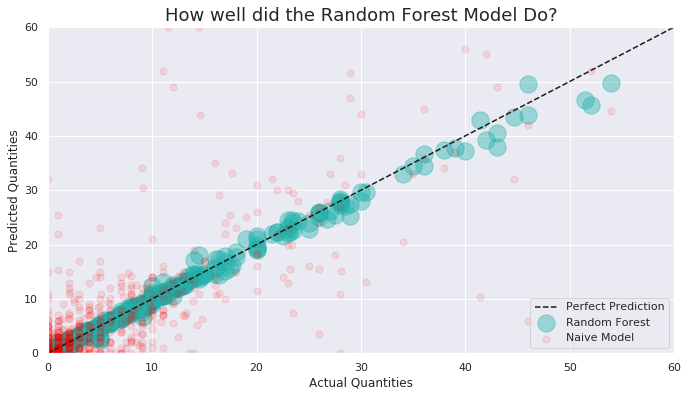

In [0]:
#Test
test.reset_index(inplace=True)
results_test = pd.concat([test, pred_vs_actual_test], axis=1, sort=False)
results_test= results_test[['item', 'weekofyear', 'actual', 'last_wk_sales','predicted', 'error_rf', 'rmse']]
results_test['error_n']= ((results_test.last_wk_sales.values- results_test.actual.values)/results_test.actual.values)*100

#Actual values versus predicted values
print ("How much better did the Random perform than the Naive Model?")
print(f'Random Forest increased performance by: {abs((error-naive_error)/naive_error) * 100: .2f} % \n')
plt.figure(figsize=(10,6))
plt.scatter(results_test.actual, results_test.predicted, s=300, color='lightseagreen', alpha= .4, label= "Random Forest")
plt.scatter(results_test.actual, results_test.last_wk_sales, s=50, color='red', alpha= .1, label= "Naive Model")

x = np.linspace(0,60,60)
y = x
plt.plot(x, y, 'k', linestyle='--', label= "Perfect Prediction")
plt.legend()
plt.ylim(0,60)
plt.xlim(0,60)
plt.xlabel('Actual Quantities')
plt.ylabel('Predicted Quantities')
plt.title("How well did the Random Forest Model Do?", fontsize= 18)

## Graphing with tree depth of 5 predictions with max trees 100

How much better did the LightGBM perform than the Naive Model?
Random Forest increased performance by:  65.90 % 



Text(0.5, 1.0, 'How well did the Random Forest Model Do?')

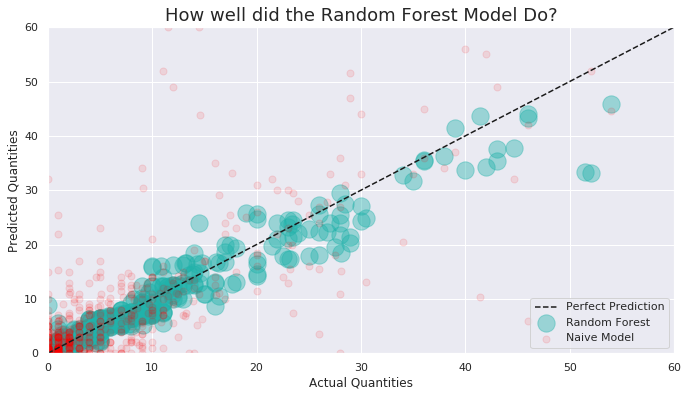

In [0]:
#Test
test.reset_index(inplace=True)
results_test = pd.concat([test, pred_vs_actual_test], axis=1, sort=False)
results_test= results_test[['item', 'weekofyear', 'actual', 'last_wk_sales','predicted', 'error_rf', 'rmse']]
results_test['error_n']= ((results_test.last_wk_sales.values- results_test.actual.values)/results_test.actual.values)*100

#Actual values versus predicted values
print ("How much better did the LightGBM perform than the Naive Model?")
print(f'Random Forest increased performance by: {abs((error-naive_error)/naive_error) * 100: .2f} % \n')
plt.figure(figsize=(10,6))
plt.scatter(results_test.actual, results_test.predicted, s=300, color='lightseagreen', alpha= .4, label= "Random Forest")
plt.scatter(results_test.actual, results_test.last_wk_sales, s=50, color='red', alpha= .1, label= "Naive Model")

x = np.linspace(0,60,60)
y = x
plt.plot(x, y, 'k', linestyle='--', label= "Perfect Prediction")
plt.legend()
plt.ylim(0,60)
plt.xlim(0,60)
plt.xlabel('Actual Quantities')
plt.ylabel('Predicted Quantities')
plt.title("How well did the Random Forest Model Do?", fontsize= 18)

# Overfitting and why test doing better than train??

* Log sales maybe over fitting it?

In [0]:

train = dfwk[dfwk['weekofyear'] < last_week] #NOTE: our training set gets smaller the further out the weeks are
test = dfwk[dfwk['weekofyear'] == last_week]
    
x_train, x_test = train.drop(['sales'], axis=1), test.drop(['sales'], axis=1)
y_train, y_test = train['sales'].values, test['sales'].values


max_depths = range(2, 14)
train_results = []
test_results = []

for max_depth in max_depths:
  rf = RandomForestRegressor(n_estimators=1000, max_depth=max_depth, n_jobs=-1)
  rf.fit(x_train, y_train)
  train_p = rf.predict(x_train)
  train_err = rmse(y_train, train_p)
  train_results.append(train_err)
  
  test_p = rf.predict(x_test)
  test_err = rmse(y_test, test_p)
  test_results.append(test_err)

Text(0.5, 0, 'Tree Depth')

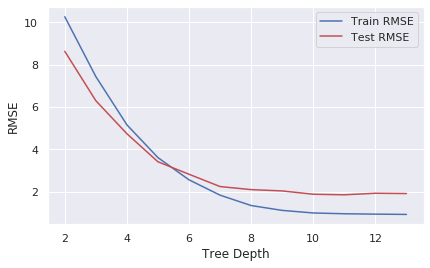

In [0]:
#Plot Tree Depth of Testing Versus Training
plt.plot(list(max_depths), train_results, color= 'b', label='Train RMSE')
plt.plot(list(max_depths), test_results, color= 'r', label='Test RMSE')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Tree Depth')


Text(0.5, 1.0, 'Most Important Features for Random Forest MODEL')

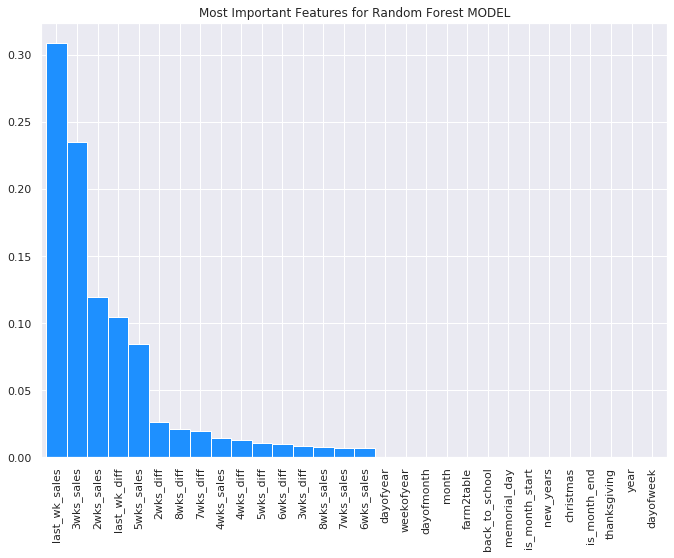

In [0]:
# feature importances
feature_importances = pd.Series(rf.feature_importances_, index=x_train.columns)
feature_importances.sort_values(inplace=True, ascending=False)
feature_importances[:50].plot.bar( color="dodgerblue", figsize= (10,8), width= 1)
plt.title("Most Important Features for Random Forest MODEL")

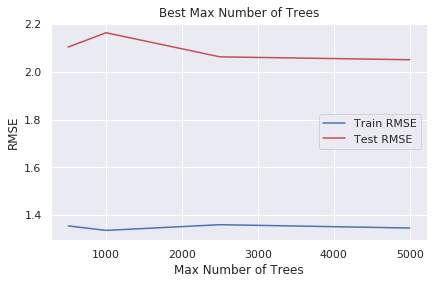

In [0]:
#Let's do the same thing for the max number of trees, and see what the optimal balance of lower RMSE without overfitting

train = dfwk[dfwk['weekofyear'] < last_week] #NOTE: our training set gets smaller the further out the weeks are
test = dfwk[dfwk['weekofyear'] == last_week]
    
x_train, x_test = train.drop(['sales'], axis=1), test.drop(['sales'], axis=1)
y_train, y_test = train['sales'].values, test['sales'].values


num_trees = [500, 1000, 2500, 5000]
train_results = []
test_results = []

for num in num_trees:
  rf = RandomForestRegressor(n_estimators=num, max_depth= 8, n_jobs=-1)
  rf.fit(x_train, y_train)
  train_p = rf.predict(x_train)
  train_err = rmse(y_train, train_p)
  train_results.append(train_err)
  
  test_p = rf.predict(x_test)
  test_err = rmse(y_test, test_p)
  test_results.append(test_err)

#Plot Tree Depth of Testing Versus Training
plt.plot(num_trees, train_results, color= 'b', label='Train RMSE')
plt.plot(num_trees, test_results, color= 'r', label='Test RMSE')
plt.legend()
plt.title("Best Max Number of Trees")
plt.ylabel('RMSE')
plt.xlabel('Max Number of Trees')
plt.show()